Welcome to the 2025 Kaggle Playground Series! We plan to continue in the spirit of previous playgrounds, providing interesting and approachable datasets for our community to practice their machine learning skills, and anticipate a competition each month.

Your Goal: Predict the likelihood of accidents on different types of roads.

For this Playground Series challenge, we have teamed up with Stack Overflow to give you a two-part challenge. The Stack Overflow Challenge is the second part and builds upon this one by having participants develop a web application. We encourage you to check out the Stack Overflow Challenge!

If you complete both challenges, we’ll recognize your breadth of skills with a special “Code Scientist” badge which will appear on both Kaggle and Stack Overflow.

# Dataset Description

The dataset for this competition (both train and test) was generated from a deep learning model trained on the Simulated Roads Accident dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

# Ensamble

In [4]:
# Retrain XGBoost and KNN with Best Parameters Found
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd 
import numpy as np


train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Refactor: Pipelines for XGBoost (native categoricals) and KNN (OHE + scaling)

# Preparar features e target
X = train.drop(['id', 'accident_risk'], axis=1)
y = train['accident_risk']
X_test_final = test.drop(['id'], axis=1, errors='ignore')  # Ignora se 'id' não existir no teste

print(f"Formato dados de treino (X): {X.shape}")
print(f"Formato dados de teste (X_test): {X_test_final.shape}")

# =============================================================================
# 2. Definir Tipos de Colunas e Pré-processamento Leve
# =============================================================================
print("\n2. Definindo tipos de colunas...")
# A 'curvature' é a única puramente numérica
numeric_cols = ['curvature']

# Todas as outras são categóricas
categorical_cols = [
    'road_type', 'lighting', 'weather', 'time_of_day',
    'num_lanes', 'num_reported_accidents', 'speed_limit'
]

# Pré-processamento leve de tipos (para o XGBoost e KNN)
def set_col_types(df):
    for col in categorical_cols:
        df[col] = df[col].astype('category')
    for col in numeric_cols:
        df[col] = df[col].astype(float)
    return df

X = set_col_types(X)
X_test_final = set_col_types(X_test_final)

# =============================================================================
# 3. Dividir os Dados (ANTES de qualquer pré-processamento)
# =============================================================================
print("\n3. Dividindo dados em treino e validação...")
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Formato treino: {X_train.shape}")
print(f"Formato validação: {X_val.shape}")

# =============================================================================
# 4. Pipeline XGBoost (com enable_categorical=True)
# =============================================================================
print("\n4. Configurando Pipeline XGBoost...")

best_xgb_params = {
    'device': 'cuda',
    'random_state': 42,
    'enable_categorical': True,  # Chave para este pipeline!
    'max_depth': 7,
    'learning_rate': 0.01,
    'n_estimators': 1000
}

# 'Binner' para a 'curvature' (fit apenas no treino via pipeline)
curvature_binner = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')

# Pré-processador do XGBoost: binariza apenas 'curvature' e mantém resto
xgb_preprocessor = ColumnTransformer(
    transformers=[
        ('binner', curvature_binner, numeric_cols),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

xgb_preprocessor.set_output(transform="pandas")

xgb_pipeline = Pipeline([
    ('preprocessor', xgb_preprocessor),
    ('model', XGBRegressor(**best_xgb_params))
])

# =============================================================================
# 5. Pipeline KNN (com One-Hot Encoding e Scaling)
# =============================================================================
print("\n5. Configurando Pipeline KNN...")

best_knn_params = {'n_neighbors': 100}

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

knn_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    verbose_feature_names_out=False
)
knn_preprocessor.set_output(transform="pandas")

knn_pipeline = Pipeline([
    ('preprocessor', knn_preprocessor),
    ('model', KNeighborsRegressor(**best_knn_params))
])

# =============================================================================
# 6. Treinamento e Avaliação
# =============================================================================
final_models = {}

print("\n" + "-" * 20)
print("6.1. Treinando XGBoost...")
print(f"Parâmetros: {best_xgb_params}")

xgb_pipeline.fit(X_train, y_train)
xgb_val_pred = xgb_pipeline.predict(X_val)

xgb_final_mse = mean_squared_error(y_val, xgb_val_pred)
xgb_final_rmse = np.sqrt(xgb_final_mse)
xgb_final_mae = mean_absolute_error(y_val, xgb_val_pred)
xgb_final_r2 = r2_score(y_val, xgb_val_pred)

print(f"\nPerformance (Validação) XGBoost:")
print(f"RMSE: {xgb_final_rmse:.6f}")
print(f"MAE: {xgb_final_mae:.6f}")
print(f"R²: {xgb_final_r2:.6f}")

final_models['XGBoost'] = {
    'model': xgb_pipeline, 'rmse': xgb_final_rmse, 'r2': xgb_final_r2
}

print("\n" + "-" * 20)
print("6.2. Treinando KNN...")
print(f"Parâmetros: {best_knn_params}")

knn_pipeline.fit(X_train, y_train)
knn_val_pred = knn_pipeline.predict(X_val)

knn_final_mse = mean_squared_error(y_val, knn_val_pred)
knn_final_rmse = np.sqrt(knn_final_mse)
knn_final_mae = mean_absolute_error(y_val, knn_val_pred)
knn_final_r2 = r2_score(y_val, knn_val_pred)

print(f"\nPerformance (Validação) KNN:")
print(f"RMSE: {knn_final_rmse:.6f}")
print(f"MAE: {knn_final_mae:.6f}")
print(f"R²: {knn_final_r2:.6f}")

final_models['KNN'] = {
    'model': knn_pipeline, 'rmse': knn_final_rmse, 'r2': knn_final_r2
}

# =============================================================================
# 7. Comparação Final
# =============================================================================
print(f"\n\n7. Comparação Final dos Modelos (Validação):")
print("=" * 45)
print(f"{'Modelo':<10} {'RMSE':<12} {'R²':<12}")
print("-" * 45)
print(f"{'XGBoost':<10} {xgb_final_rmse:<12.6f} {xgb_final_r2:<12.6f}")
print(f"{'KNN':<10} {knn_final_rmse:<12.6f} {knn_final_r2:<12.6f}")

best_model_name = 'XGBoost' if xgb_final_rmse < knn_final_rmse else 'KNN'
print(f"\nMelhor modelo: {best_model_name}")

# =============================================================================
# 8. Treinar o melhor modelo em todos os dados e prever no teste
# =============================================================================
print(f"\n8. Treinando modelo final ({best_model_name}) em todos os dados (X, y)...")

best_model_pipeline = xgb_pipeline if best_model_name == 'XGBoost' else knn_pipeline
best_model_pipeline.fit(X, y)

print("Gerando previsões no dataset de teste...")
final_predictions = best_model_pipeline.predict(X_test_final)

print("Previsões geradas (10 primeiras):")
print(final_predictions[:10])

# (Opcional) salvar submissão
# submission = pd.DataFrame({'id': test['id'], 'accident_risk': final_predictions})
# submission.to_csv('submission.csv', index=False)
# print("\nArquivo 'submission.csv' salvo com sucesso!")

print("\nScript finalizado!")


Formato dados de treino (X): (517754, 12)
Formato dados de teste (X_test): (172585, 12)

2. Definindo tipos de colunas...

3. Dividindo dados em treino e validação...
Formato treino: (414203, 12)
Formato validação: (103551, 12)

4. Configurando Pipeline XGBoost...

5. Configurando Pipeline KNN...

--------------------
6.1. Treinando XGBoost...
Parâmetros: {'device': 'cuda', 'random_state': 42, 'enable_categorical': True, 'max_depth': 7, 'learning_rate': 0.01, 'n_estimators': 1000}


d:\repositorios_pessoais\Predicting-Road-Accident-Risk\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
d:\repositorios_pessoais\Predicting-Road-Accident-Risk\.venv\Lib\site-packages\xgboost\core.py:729: UserWarning: [15:48:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.



Performance (Validação) XGBoost:
RMSE: 0.057105
MAE: 0.044388
R²: 0.881901

--------------------
6.2. Treinando KNN...
Parâmetros: {'n_neighbors': 100}

Performance (Validação) KNN:
RMSE: 0.062719
MAE: 0.048991
R²: 0.857540


7. Comparação Final dos Modelos (Validação):
Modelo     RMSE         R²          
---------------------------------------------
XGBoost    0.057105     0.881901    
KNN        0.062719     0.857540    

Melhor modelo: XGBoost

8. Treinando modelo final (XGBoost) em todos os dados (X, y)...


d:\repositorios_pessoais\Predicting-Road-Accident-Risk\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


Gerando previsões no dataset de teste...
Previsões geradas (10 primeiras):
[0.2991405  0.12231119 0.20017043 0.32376072 0.4111298  0.4580254
 0.25900075 0.20051715 0.36970258 0.30453444]

Script finalizado!


In [6]:
# =============================================================================
# 9. Métodos de Ensemble: Combinando KNN e XGBoost
# =============================================================================
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
# As métricas (mean_squared_error, etc.) e numpy (np) já foram importadas no script anterior.

print("\n\n" + "=" * 60)
print("9. Implementando Métodos de Ensemble (KNN + XGBoost)...")
print("=" * 60)

# =============================================================================
# 9.1. Método 1: Média Ponderada (Weighted Average)
# =============================================================================
print("\n9.1. Ensemble por Média Ponderada")
print("-" * 30)

# Buscar os RMSEs calculados na Etapa 6 e armazenados em 'final_models'
xgb_rmse = final_models['XGBoost']['rmse']
knn_rmse = final_models['KNN']['rmse']

# Calcular pesos com base no inverso do RMSE
# Um RMSE menor deve ter um peso maior
xgb_weight = 1 / xgb_rmse
knn_weight = 1 / knn_rmse

# Normalizar os pesos para que somem 1
total_weight = xgb_weight + knn_weight
xgb_weight = xgb_weight / total_weight
knn_weight = knn_weight / total_weight

print(f"XGBoost RMSE (Val): {xgb_rmse:.6f} - Peso: {xgb_weight:.4f}")
print(f"KNN RMSE (Val): {knn_rmse:.6f} - Peso: {knn_weight:.4f}")
print(f"Soma dos pesos: {xgb_weight + knn_weight:.4f}")

# --- ADAPTAÇÃO ---
# Usar as predições de validação 'xgb_val_pred' e 'knn_val_pred' geradas na Etapa 6
# (O script original tentava acessar 'final_models['...']['predictions']', que não existia)
weighted_val_predictions = (xgb_weight * xgb_val_pred + 
                            knn_weight * knn_val_pred)

# --- ADAPTAÇÃO ---
# Calcular métricas contra 'y_val' (o conjunto de validação real)
# (O script original usava 'y_val_final')
ensemble_rmse = np.sqrt(mean_squared_error(y_val, weighted_val_predictions))
ensemble_mae = mean_absolute_error(y_val, weighted_val_predictions)
ensemble_r2 = r2_score(y_val, weighted_val_predictions)

print(f"\nPerformance (Validação) Média Ponderada:")
print(f"RMSE: {ensemble_rmse:.6f}")
print(f"MAE: {ensemble_mae:.6f}")
print(f"R²: {ensemble_r2:.6f}")

# =============================================================================
# 9.2. Método 2: Stacking Regressor
# =============================================================================
print("\n9.2. Ensemble com Stacking Regressor")
print("-" * 30)

# Criar a lista de estimadores base
# Os pipelines já foram treinados na Etapa 6, mas o StackingRegressor
# com cv=5 irá cloná-los e retreiná-los internamente nas folds de CV.
base_models = [
    ('xgb', final_models['XGBoost']['model']),
    ('knn', final_models['KNN']['model'])
]

# Criar o Stacking Regressor com uma Regressão Linear como meta-modelo
stacking_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=RidgeCV(),
    cv=5,      # Usa validação cruzada para gerar as predições para o meta-modelo
    n_jobs=-1,
    passthrough=False # Apenas as predições dos modelos base vão para o meta-modelo
)

print("Treinando o Stacking Regressor...")
# --- ADAPTAÇÃO ---
# Treinar o stacker nos dados de TREINO (X_train, y_train)
# (O script original usava 'X_train_final', 'y_train_final')
stacking_regressor.fit(X_train, y_train)

print("Avaliando o Stacking Regressor nos dados de validação...")
# --- ADAPTAÇÃO ---
# Fazer predições no conjunto de VALIDAÇÃO (X_val)
# (O script original usava 'X_val_final')
stacking_val_predictions = stacking_regressor.predict(X_val)

# --- ADAPTAÇÃO ---
# Calcular métricas contra 'y_val'
# (O script original usava 'y_val_final')
stacking_rmse = np.sqrt(mean_squared_error(y_val, stacking_val_predictions))
stacking_mae = mean_absolute_error(y_val, stacking_val_predictions)
stacking_r2 = r2_score(y_val, stacking_val_predictions)

print(f"\nPerformance (Validação) Stacking Regressor:")
print(f"RMSE: {stacking_rmse:.6f}")
print(f"MAE: {stacking_mae:.6f}")
print(f"R²: {stacking_r2:.6f}")

# =============================================================================
# 9.3. Comparação dos Ensembles
# =============================================================================
print(f"\n\n9.3. Comparação Final dos Ensembles (Validação):")
print("=" * 50)
print(f"{'Método':<20} {'RMSE':<12} {'R²':<12}")
print("-" * 50)
print(f"{'XGBoost (Base)':<20} {xgb_final_rmse:<12.6f} {xgb_final_r2:<12.6f}")
print(f"{'KNN (Base)':<20} {knn_final_rmse:<12.6f} {knn_final_r2:<12.6f}")
print(f"{'Média Ponderada':<20} {ensemble_rmse:<12.6f} {ensemble_r2:<12.6f}")
print(f"{'Stacking':<20} {stacking_rmse:<12.6f} {stacking_r2:<12.6f}")
print("=" * 50)

# Armazenar resultados do ensemble
ensemble_results = {
    'weighted_average': {
        'model': None,  # Não é um modelo treinável, apenas pesos
        'weights': {'xgb': xgb_weight, 'knn': knn_weight},
        'rmse': ensemble_rmse,
        'mae': ensemble_mae,
        'r2': ensemble_r2,
        'val_predictions': weighted_val_predictions # Salva as predições da validação
    },
    'stacking': {
        'model': stacking_regressor, # O modelo de stacking treinado
        'rmse': stacking_rmse,
        'mae': stacking_mae,
        'r2': stacking_r2,
        'val_predictions': stacking_val_predictions # Salva as predições da validação
    }
}

print("\nImplementação do Ensemble finalizada!")



9. Implementando Métodos de Ensemble (KNN + XGBoost)...

9.1. Ensemble por Média Ponderada
------------------------------
XGBoost RMSE (Val): 0.057105 - Peso: 0.5234
KNN RMSE (Val): 0.062719 - Peso: 0.4766
Soma dos pesos: 1.0000

Performance (Validação) Média Ponderada:
RMSE: 0.058188
MAE: 0.045322
R²: 0.877380

9.2. Ensemble com Stacking Regressor
------------------------------
Treinando o Stacking Regressor...
Avaliando o Stacking Regressor nos dados de validação...

Performance (Validação) Stacking Regressor:
RMSE: 0.057012
MAE: 0.044310
R²: 0.882284


9.3. Comparação Final dos Ensembles (Validação):
Método               RMSE         R²          
--------------------------------------------------
XGBoost (Base)       0.057105     0.881901    
KNN (Base)           0.062719     0.857540    
Média Ponderada      0.058188     0.877380    
Stacking             0.057012     0.882284    

Implementação do Ensemble finalizada!


## Predict with full data

In [8]:
# =============================================================================
# 10. GERAÇÃO DE PREVISÕES FINAIS (NO CONJUNTO DE TESTE)
# =============================================================================
# (Assume que 'X', 'y', 'X_test_final', 'test' já estão carregados)
# (Assume que 'xgb_pipeline', 'knn_pipeline' estão definidos)
# (Assume que 'final_models' e 'ensemble_results' existem da Etapa 9)
# (Assume que 'RidgeCV', 'StackingRegressor', 'pd' estão importados)

print("\n\n" + "=" * 60)
print("10. Gerando Previsões Finais no Conjunto de Teste...")
print("=" * 60)

# ---
# A. Treinar os modelos base em TODOS os dados (X, y)
# ---
print("Treinando modelos base (XGB e KNN) em todos os dados (X, y)...")

xgb_pipeline.fit(X, y)
knn_pipeline.fit(X, y)
print("Modelos base treinados.")

# ---
# B. Gerar previsões base no conjunto de teste (X_test_final)
# ---
print("Gerando previsões base no conjunto de teste...")
xgb_test_pred = xgb_pipeline.predict(X_test_final)
knn_test_pred = knn_pipeline.predict(X_test_final)

# =============================================================================
# 10.1. Predição Final (Ensemble por Média Ponderada)
# =============================================================================
print("\n10.1. Calculando previsões finais da Média Ponderada...")

# Usar os mesmos pesos calculados na Etapa 9 (baseados na validação)
xgb_rmse = final_models['XGBoost']['rmse']
knn_rmse = final_models['KNN']['rmse']

xgb_weight = 1 / xgb_rmse
knn_weight = 1 / knn_rmse
total_weight = xgb_weight + knn_weight
xgb_weight = xgb_weight / total_weight
knn_weight = knn_weight / total_weight

print(f"Pesos (Validação): XGB={xgb_weight:.4f}, KNN={knn_weight:.4f}")

# Criar predições finais ponderadas
weighted_test_predictions = (xgb_weight * xgb_test_pred + 
                             knn_weight * knn_test_pred)

print("Previsões da Média Ponderada (10 primeiras):")
print(weighted_test_predictions[:10])

# =============================================================================
# 10.2. Predição Final (Stacking Regressor)
# =============================================================================
print("\n10.2. Treinando e prevendo com o Stacking Regressor Final...")

# Criar os estimadores base (usando as definições dos pipelines)
base_models = [
    ('xgb', final_models['XGBoost']['model']), # Reutiliza a definição do pipeline
    ('knn', final_models['KNN']['model'])   # Reutiliza a definição do pipeline
]

# Criar o stacking regressor final com RidgeCV
# (Defina os alphas se desejar, ex: alphas=np.logspace(-2, 2, 10))
stacking_regressor_final = StackingRegressor(
    estimators=base_models,
    final_estimator=RidgeCV(),
    cv=5,      # O CV interno será feito nos dados (X, y)
    n_jobs=-1,
    passthrough=False
)

print("Treinando Stacking Regressor em todos os dados (X, y)...")
# Treina o stacker completo no dataset de treino inteiro
stacking_regressor_final.fit(X, y)

print("Gerando previsões finais com o Stacking Regressor...")
# Gera as previsões no conjunto de teste
stacking_test_predictions = stacking_regressor_final.predict(X_test_final)

print("Previsões do Stacking (10 primeiras):")
print(stacking_test_predictions[:10])

# =============================================================================
# 10.3. Salvar AMBAS as Submissões
# =============================================================================
print("\n10.3. Criando e salvando arquivos de submissão...")

# ---
# 1. Criar DataFrame para Média Ponderada
# ---
submission_weighted = pd.DataFrame({
    'id': test['id'], 
    'accident_risk': weighted_test_predictions  # Usa as previsões ponderadas
})

# Salvar o arquivo da Média Ponderada
submission_filename_weighted = 'submission_WeightedAvg.csv'
submission_weighted.to_csv(submission_filename_weighted, index=False)

print(f"Arquivo '{submission_filename_weighted}' salvo com sucesso!")

# ---
# 2. Criar DataFrame para Stacking
# ---
submission_stacking = pd.DataFrame({
    'id': test['id'], 
    'accident_risk': stacking_test_predictions  # Usa as previsões do stacking
})

# Salvar o arquivo do Stacking
submission_filename_stacking = 'submission_Stacking.csv'
submission_stacking.to_csv(submission_filename_stacking, index=False)

print(f"Arquivo '{submission_filename_stacking}' salvo com sucesso!")

# ---
# 3. (Opcional) Imprimir qual foi o melhor na validação
# ---
print("-" * 40)
print(f"Comparação (Validação):")

# === INÍCIO DA CORREÇÃO ===
# Buscar os RMSEs do dicionário 'ensemble_results' criado na Etapa 9
weighted_val_rmse = ensemble_results['weighted_average']['rmse']
stacking_val_rmse = ensemble_results['stacking']['rmse']
# === FIM DA CORREÇÃO ===

print(f"RMSE Média Ponderada (Val): {weighted_val_rmse:.6f}")
print(f"RMSE Stacking (Val): {stacking_val_rmse:.6f}")

if weighted_val_rmse < stacking_val_rmse:
    print("-> Melhor modelo na validação: Média Ponderada")
else:
    print("-> Melhor modelo na validação: Stacking")

print("\nScript finalizado! Ambos os arquivos de submissão foram gerados.")



10. Gerando Previsões Finais no Conjunto de Teste...
Treinando modelos base (XGB e KNN) em todos os dados (X, y)...


d:\repositorios_pessoais\Predicting-Road-Accident-Risk\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


Modelos base treinados.
Gerando previsões base no conjunto de teste...

10.1. Calculando previsões finais da Média Ponderada...
Pesos (Validação): XGB=0.5234, KNN=0.4766
Previsões da Média Ponderada (10 primeiras):
[0.3012439  0.14570366 0.19844383 0.33514552 0.39956999 0.43094262
 0.26366192 0.20464361 0.36238921 0.312838  ]

10.2. Treinando e prevendo com o Stacking Regressor Final...
Treinando Stacking Regressor em todos os dados (X, y)...
Gerando previsões finais com o Stacking Regressor...
Previsões do Stacking (10 primeiras):
[0.29900915 0.12575262 0.1958586  0.32799854 0.40887597 0.45125738
 0.2591854  0.19842417 0.36789545 0.30683651]

10.3. Criando e salvando arquivos de submissão...
Arquivo 'submission_WeightedAvg.csv' salvo com sucesso!
Arquivo 'submission_Stacking.csv' salvo com sucesso!
----------------------------------------
Comparação (Validação):
RMSE Média Ponderada (Val): 0.058188
RMSE Stacking (Val): 0.057012
-> Melhor modelo na validação: Stacking

Script finalizad



11. Análise e Visualização das Previsões Finais (Teste)
Salvando arquivos de submissão para AMBOS os ensembles...
Submissão do Stacking salva como 'stacking_submission_df.csv'
Submissão da Média Ponderada salva como 'weighted_submission_df.csv'

Estatísticas das Previsões de Teste:
Modelo     Mean         Std          Min          Max         
------------------------------------------------------------
Stacking   0.351644     0.156875     -0.001201    0.879660    
Weighted   0.350426     0.147141     0.031730     0.842250    

Correlação entre as previsões (Stacking vs Weighted): 0.999148

Gerando visualização das distribuições das previsões...


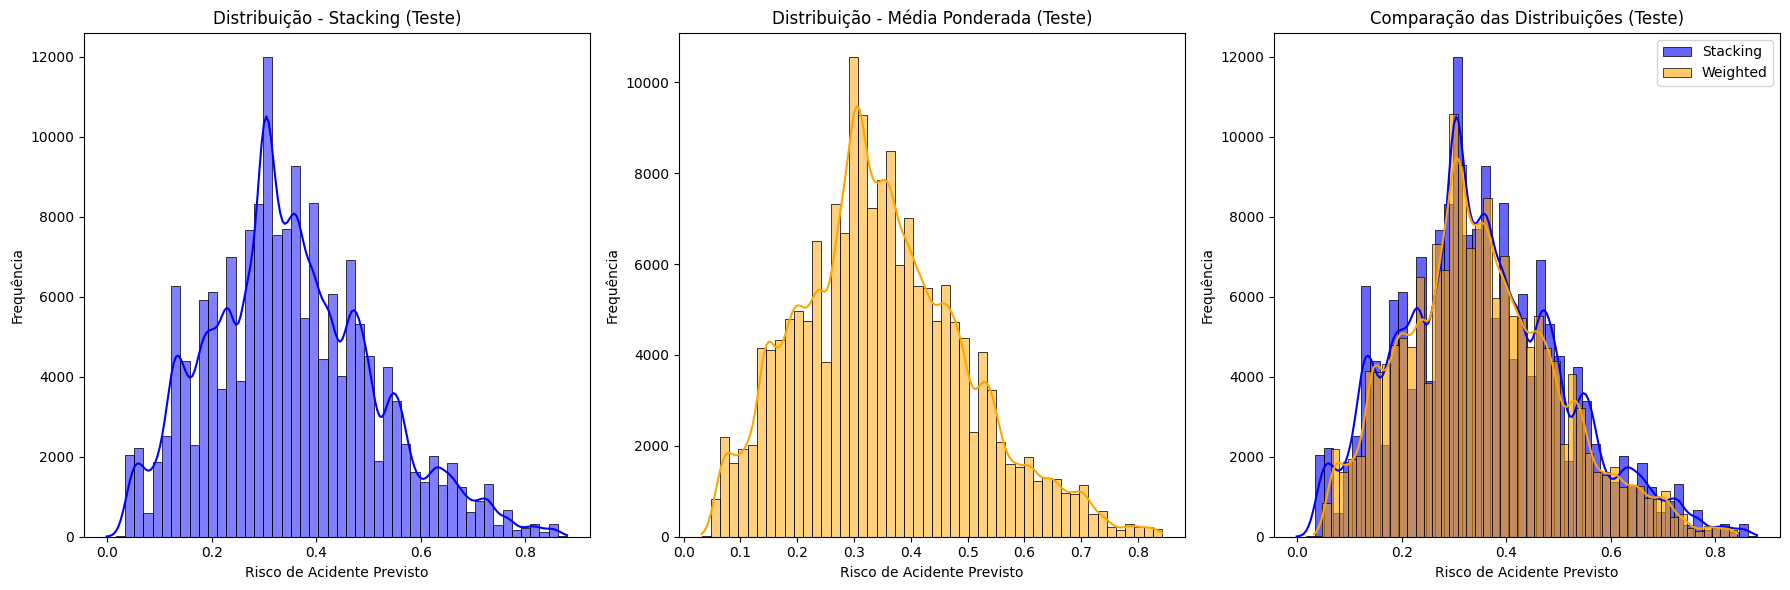


Análise de visualização finalizada!


In [9]:
# =============================================================================
# 11. ANÁLISE FINAL E VISUALIZAÇÃO DAS PREVISÕES DE TESTE
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
# (Assume-se que 'pd' e 'np' já estão importados)

print("\n\n" + "=" * 60)
print("11. Análise e Visualização das Previsões Finais (Teste)")
print("=" * 60)

# -----------------------------------------------------------------------------
# 11.1. Criar DataFrames de Submissão
# -----------------------------------------------------------------------------
# (Nota: O script anterior da Etapa 10 já salvou o *melhor* modelo.
# Este bloco salva ambos os ensembles para comparação, o que é ótimo!)

print("Salvando arquivos de submissão para AMBOS os ensembles...")

stacking_submission_df = pd.DataFrame({
    'id': test['id'],
    # --- ADAPTADO ---
    'accident_risk': stacking_test_predictions 
})

weighted_submission_df = pd.DataFrame({
    'id': test['id'],
    # --- ADAPTADO ---
    'accident_risk': weighted_test_predictions
})

stacking_submission_df.to_csv('stacking_submission_df.csv', index=False)
print("Submissão do Stacking salva como 'stacking_submission_df.csv'")

weighted_submission_df.to_csv('weighted_submission_df.csv', index=False)
print("Submissão da Média Ponderada salva como 'weighted_submission_df.csv'")

# -----------------------------------------------------------------------------
# 11.2. Comparação Estatística
# -----------------------------------------------------------------------------
print(f"\nEstatísticas das Previsões de Teste:")
print("=" * 60)
print(f"{'Modelo':<10} {'Mean':<12} {'Std':<12} {'Min':<12} {'Max':<12}")
print("-" * 60)
# --- ADAPTADO ---
print(f"{'Stacking':<10} {stacking_test_predictions.mean():<12.6f} {stacking_test_predictions.std():<12.6f} {stacking_test_predictions.min():<12.6f} {stacking_test_predictions.max():<12.6f}")
print(f"{'Weighted':<10} {weighted_test_predictions.mean():<12.6f} {weighted_test_predictions.std():<12.6f} {weighted_test_predictions.min():<12.6f} {weighted_test_predictions.max():<12.6f}")

# Correlação entre as previsões
# --- ADAPTADO ---
prediction_correlation = np.corrcoef(stacking_test_predictions, weighted_test_predictions)[0, 1]
print(f"\nCorrelação entre as previsões (Stacking vs Weighted): {prediction_correlation:.6f}")

# -----------------------------------------------------------------------------
# 11.3. Visualização das Distribuições
# -----------------------------------------------------------------------------
print("\nGerando visualização das distribuições das previsões...")


plt.figure(figsize=(18, 6)) # Aumentei um pouco a largura

# Distribuição do Stacking
plt.subplot(1, 3, 1)
# --- ADAPTADO ---
sns.histplot(stacking_test_predictions, bins=50, kde=True, color='blue')
plt.title('Distribuição - Stacking (Teste)')
plt.xlabel('Risco de Acidente Previsto')
plt.ylabel('Frequência')

# Distribuição da Média Ponderada
plt.subplot(1, 3, 2)
# --- ADAPTADO ---
sns.histplot(weighted_test_predictions, bins=50, kde=True, color='orange')
plt.title('Distribuição - Média Ponderada (Teste)')
plt.xlabel('Risco de Acidente Previsto')
plt.ylabel('Frequência')

# Comparação sobreposta
plt.subplot(1, 3, 3)
# --- ADAPTADO ---
sns.histplot(stacking_test_predictions, bins=50, kde=True, color='blue', label='Stacking', alpha=0.6)
sns.histplot(weighted_test_predictions, bins=50, kde=True, color='orange', label='Weighted', alpha=0.6)
plt.title('Comparação das Distribuições (Teste)')
plt.xlabel('Risco de Acidente Previsto')
plt.ylabel('Frequência')
plt.legend()

plt.tight_layout()
plt.show()

print("\nAnálise de visualização finalizada!")